
<a id='iterative-methods-sparsity'></a>

# Conditioning and Iterative Methods

## Contents

- [Conditioning and Iterative Methods](#Conditioning-and-Iterative-Methods)  
  - [Overview](#Overview)  
  - [Ill-Conditioned Matrices](#Ill-Conditioned-Matrices)  
  - [Stationary Iterative Algorithms for Linear Systems](#Stationary-Iterative-Algorithms-for-Linear-Systems)  
  - [Krylov Methods](#Krylov-Methods)  

## Overview

This lecture takes the structure of :doc:` numerical methods for linear algebra <numerical_linear_algebra>` and builds further
towards working with large, sparse matrices.  In the process, we will examine foundational numerical analysis such as
ill-conditioned matrices.

### Setup

In [1]:
using LinearAlgebra, Statistics, BenchmarkTools, Random
Random.seed!(42);  # seed random numbers for reproducibility

## Ill-Conditioned Matrices

An important consideration in numerical linear algebra, and iterative methods in general is the [condition number](https://en.wikipedia.org/wiki/Condition_number#Matrices).

An ill-conditioned matrix is one where the basis of eigenvectors are close to, but not exactly, collinear.  While this poses no problem on pen and paper,
or with infinite precision numerical methods, it is an important issue in practice for two reasons

1. Ill-conditioned matrices introduce numerical errors roughly in proportion to the base-10 log of the condition number.  
1. The convergence speed of many iterative methods is based on the spectral properties (e.g. the basis formed by the eigenvectors), and hence ill-conditioned systems can converge slowly.  


The solutions to these problems are to

- be careful with operations which introduce error based on the condition number (e.g. matrix inversions when the condition number is high)  
- where possible, choose alternative representations which have less collinearity (e.g. an orthogonal polynomial basis rather than a monomial one)  
- for iterative methods, use a preconditioner, which changes the spectral properties to increase acceleration speed  

### Condition Number

First, lets define the condition number and example it

$$
\kappa(A) = \|A\| \|A^{-1}\|
$$

where you can use the Cauchy–Schwarz inequality to show that $ \kappa(A) \geq 1 $.  You can choose any norm, but the 2-norm is a good default.

First, a warning on calculations: calculating the condition number for a matrix can be an expensive operation (as would calculating a determinant)
and should be thought of as roughly equivalent to doing an eigendecomposition.  So use it for detective work judiciously.

Lets look at the condition number of a few matrices using the `cond` function (which allows a choice of the norm, but we stick with the 2-norm).

In [2]:
A = I(2)
cond(A)

1.0

Here we see an example of the best-conditioned matrix, the identity matrix with its completely orthonormal basis, is 1.

On the other hand, notice that

In [3]:
ϵ = 1E-6
A = [1.0 0.0
     1.0 ϵ]
cond(A)

2.0000000000005004e6

Has a condition number of close to 100,000 - and hence (taking the base 10 log) you would expect to be introducing numerical errors of around 6 digits if you
are not careful.  For example, note that the inverse has both extremely large and extremely small numbers

In [4]:
inv(A)

2×2 Array{Float64,2}:
  1.0    0.0  
 -1.0e6  1.0e6

Since we know that the determinant of nearly collinear matrices is close to zero, this shows another symptom of poor conditioning

In [5]:
det(A)

1.0e-6

However, be careful since the determinant has a scale, while the condition number is dimensionless.  That is

In [6]:
@show det(1000 * A)
@show cond(1000 * A);

det(1000A) = 1.0
cond(1000A) = 2.0000000000005e6


In that case, the determinant of `A` is 1, while the condition number is unchanged.  This example also provides some
intuition that ill-conditioned matrices typically occur when a matrix has radically different scales (e.g. contains both `1` and `1E-6`, or `1000` and `1E-3`).  This can occur frequently with both function approximation and linear-least squares.

### Why Monomial Basis are a Bad Idea

A classic example of poorly conditioned matrices is using a monomial basis of a polynomial with interpolation.

Take a grid of points, $ x_0, \ldots x_N $ and values $ y_0, \ldots y_N $ where we want to calculate the
interpolating polynomial.

If we were to use the “obvious” polynomial basis, then the calculation is to calculate the coefficients $ c_1, \ldots c_n $ where

$$
P(x) = \sum_{i=0}^N c_i x^i
$$

To solve for the coefficients, we notice that this is a simple system of equations

$$
\begin{array}
    \,y_0 = c_0 + c_1 x_0 + \ldots c_N x_0^N\\
    \,\ldots\\
    \,y_N = c_0 + c_1 x_N + \ldots c_N x_N^N
\end{array}
$$

Or, stacking as matrices and vectors $ c = \begin{bmatrix} c_0 & \ldots & c_N\end{bmatrix}, y = \begin{bmatrix} y_0 & \ldots & y_N\end{bmatrix} $ and

$$
A = \begin{bmatrix} 1 & x_0 & x_0^2 & \ldots &x_0^N\\
                    \vdots & \vdots & \vdots & \vdots & \vdots \\
                    1 & x_N & x_N^2 & \ldots & x_N^N
    \end{bmatrix}
$$

We can then calculate the interpolating coefficients as the solution to

$$
A c = y
$$

Lets see this in operation

In [7]:
N = 5
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate

A = [x_i^n for x_i in x, n in 0:N]
A_inv = inv(A)
c = A_inv * y
norm(A * c - f.(x), Inf)

1.1932570487260818e-9

The final step is to loop.  The Inf-norm (i.e. maximum difference) of the interpolation errors is around `1E-9` which
is reasonable for many problems.

But note that with $ N=5 $ the condition number is already into the tens of thousands.

In [8]:
cond(A)

564652.3214000977

What if we increase the degree of the polynomial with the hope of increasing the precision of the
interpolation?

In [9]:
N = 10
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate

A = [x_i^n for x_i in x, n in 0:N]
A_inv = inv(A)
c = A_inv * y
norm(A * c - f.(x), Inf)

6.227055564522743e-6

Here, we see that the the increasing precision is backfiring and by going to the modest basis of 10 we have
introduced an error of about `1E-6`, even at the interpolation points.

This blows up quickly

In [10]:
N = 20
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate

A = [x_i^n for x_i in x, n in 0:N]
A_inv = inv(A)
c = A_inv * y
norm(A * c - f.(x), Inf)

35556.55954673688

To see the source of the issue, we can check to see condition number is astronomical.

In [11]:
cond(A)

7.288836972639618e24

At this point, you should be suspicious of the use of `inv(A)` since we have considered solving
linear systems by taking the inverse as verboten.  Indeed, this didn’t help and we see the
error drop dramatically.

In [12]:
c = A \ y
norm(A * c - f.(x), Inf)

3.4651748137548566e-10

But an error of `1E-10` at the interpolating nodes themselves can be an issue in many applications, and if you increase `N`
then the error will become non-trivial quickly - even without taking the inverse.

At the heart of the issue is that the monomial basis leads to a [Vandermonde_matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix) which
is especially ill-conditioned.

We can also understand a separate type of errors called [Runge’s Phenomena](https://en.wikipedia.org/wiki/Runge%27s_phenomenon).    It is an important
issue in approximation theory, albeit not one driven by numerical error themselves.

It turns out that using a uniform grid of points is close to the worst possible choice of interpolation nodes for a polynomial approximation.  This phenomena is can be seen with the interpolation of the seemingly innocuous Runge’s function, $ g(x) = \frac{1}{1 + 25 x^2} $.

Let us interpolate this function using the monomial basis above to find the $ c_i $ such that

$$
\frac{1}{(1 + 25 x^2} \approx \sum_{i=0}^N c_i x^i
$$

Implementing, where we know that for `N=5` the numerical error from being ill-conditioning is manageable, we see the
approximation has large errors at the corners.

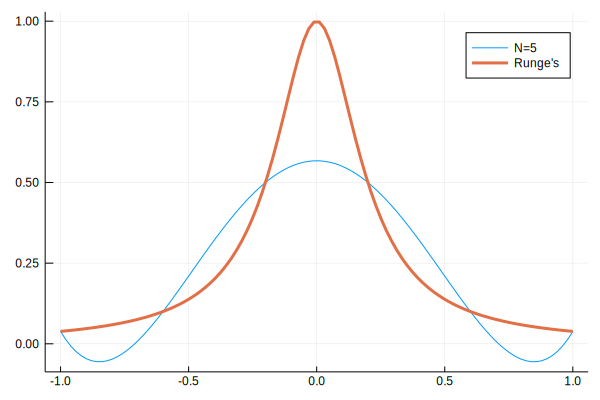

In [13]:
using Plots
N_display = 100
g(x) = 1/(1 + 25x^2)
x_display = range(-1, 1, length = N_display)
y_display = g.(x_display)

# interpolation
N = 5
x = range(-1.0, 1.0, length = N+1)
y = g.(x)
A_5 = [x_i^n for x_i in x, n in 0:N]
c_5 = A_5 \ y

# use the coefficients to evaluate on x_display grid
B_5 = [x_i^n for x_i in x_display, n in 0:N]   # calculate monomials for display grid
y_5 = B_5 * c_5  # calculates for each in x_display_grid
plot(x_display, y_5, label = "N=5")
plot!(x_display, y_display, w = 3, label = "Runge's")

This has the hallmark oscillations near the boundaries of Runge’s Phenomena.  You might guess that increasing the number
of grid points and order of the polynomial will lead to better approximations

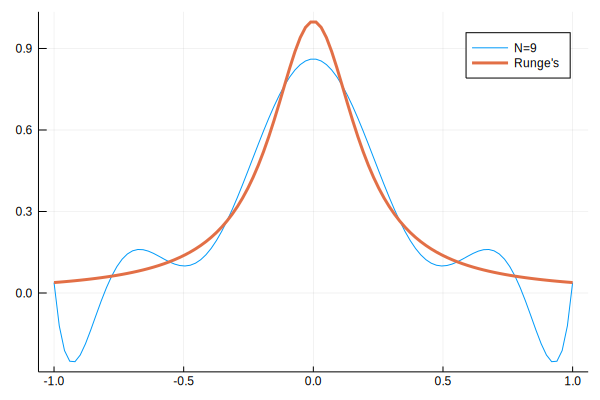

In [14]:
N = 9
x = range(-1.0, 1.0, length = N+1)
y = g.(x)
A_9 = [x_i^n for x_i in x, n in 0:N]
c_9 = A_9 \ y

# use the coefficients to evaluate on x_display grid
B_9 = [x_i^n for x_i in x_display, n in 0:N]   # calculate monomials for display grid
y_9 = B_9 * c_9  # calculates for each in x_display_grid
plot(x_display, y_9, label = "N=9")
plot!(x_display, y_display, w = 3, label = "Runge's")

Instead, we see that while the approximation is better near `x=0`, the oscillations near the boundaries have become worse.

### Using an Orthogonal Polynomial Basis

We can minimize the numerical issues of an ill-conditioned matrix by choosing a different basis for the polynomials.

For example, with [Chebyshev polymomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials), which form an orthonormal basis, we can form precise high-order approximations, with very little numerical error

In [15]:
using ApproxFun
N = 10000
S = Chebyshev(0.0..10.0)  # form chebyshev basis
x = points(S, N)  # chooses better grid points, but that could be modified
y = f.(x)
f_approx = Fun(S,ApproxFun.transform(S,y))  # transform fits the polynomial
norm(f_approx.(x) - exp.(x), Inf)

3.637978807091713e-11

Besides the use of a different polynomial basis, we are approximating at different nodes (i.e. [Chebyshev nodes](https://en.wikipedia.org/wiki/Chebyshev_nodes)).  Interpolation with Chebyshev polynomials at the Chebyshev nodes ends up minimizing (but not eliminating) Runge’s Phenomena.

To summarize the analysis,

1. Check the condition number on systems you suspect might be ill-conditioned (based on intuition of collinearity).  
1. If you are working with ill-conditioned matrices, be especially careful not to take inverse.  
1. Avoid a monomial polynomial basis.  Instead, orthogonal polynomials (e.g. Chebyshev or Lagrange) which are orthogonal under the inner product, or non-global basis such as cubic-splines.  
1. If possible, avoid using a uniform grid for interpolation and approximation and choose nodes appropriate for the basis.  


However, sometimes you can’t avoid ill-conditioned matrices. This is especially common with discretization of PDEs and with linear-least squares.

## Stationary Iterative Algorithms for Linear Systems

As before, consider solving the equation

$$
A x = b
$$

where we will maintain a solution that, if $ A $ is square, there is a unique solution.  However, we will now
focus on cases where $ A $ is both massive, sparse (e.g. potentially billions of equations), and sometimes ill-conditioned.

While this may seem excessive, it occurs in practice due to the curse of dimensionality, discretizations
of PDEs, and when working with big or network data.

The methods in the previous lectures (e.g. factorization and the related Gaussian elimination) are called direct methods, and able
in theory to converge to the exact solution in a finite number of steps while working with the matrix.  As we saw before, solving a dense linear
system without any structure takes $ O(N^3) $ operations, while a sparse system depends on the number of non-zeros.

Instead, iterative solutions start with a guess on a solution and iterate until until asymptoptic convergence.  The benefit will be that
each iteration uses a much lower order operation (e.g. an $ O(N^2) $ matrix-vector product) which will make it possible to both: (1)
solve much larger systems, even if done less precisely and (2) define linear operators in terms of the matrix-vector products directly; and (3) find solutions
in progress prior to the completion of all algorithm steps.

So, rather than always thinking of linear operators as being matrices, we will consider linear operators that may or may not fit in memory (leading to “matrix-free methods”), but implement a left-multiply `*` operator for vectors.

There are two types of iterative methods we will consider:  first are stationary methods which iterate on a map, in a similar way to fixed point problems (and which sometimes have similar contraction mapping requirements) and the second are krylov methods which iteratively solve using a basis of the matrices.

For our main examples, lets solve the valuation of the continuous time markov chain from the previous section.  That is, given a payoff vector $ r $, a
discount rate $ \rho $, and the infinitesimal generator of the markov chain $ Q $, solve the equation

$$
\rho v = r + Q v
$$

With the sizes and types of matrices here, iterative methods are inappropriate in practice, but it will help us understand
the characteristics of convergence, and how they relate to matrix conditioning.

### Stationary Methods

First, we will solve with a direct methods, which will give the solution to machine precision.

In [16]:
using LinearAlgebra, IterativeSolvers, Statistics
α = 0.1
N = 100
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))

r = range(0.0, 10.0, length=N)
ρ = 0.05

A = ρ * I - Q
v_direct = A \ r
mean(v_direct)

100.00000000000004

Without proof, consider given the discount rate of $ \rho > 0 $ this problem could be setup as a contraction for solving the Bellman
equation through methods like value function iteration.

The condition we will examine here is called [**diagonal dominance**](https://en.wikipedia.org/wiki/Diagonally_dominant_matrix).

$$
|A_{ii}| \geq \sum_{j\neq i} |A_{ij}| \quad\text{for all } i = 1\ldots N
$$

That is, for every row, the diagonal is weakly greater in absolute value than the sum of all of the other elements in the row.  In cases
where it is strictly greater, we say that the matrix is strictly diagonally dominant.

With our example, given that $ Q $ is the infinitesimal generator of a markov chain, we know that each row sums to 0, and hence
it is weakly diagonally dominant.

However, notice that when $ \rho > 0 $,  $ A = ρ * I - Q $ makes the matrix strictly diagonally dominant.

### Jacobi Iteration

For matrices that are **strictly diagonally dominant**, you can prove that a simple decomposition and iteration procedure
will converge.

To solve a system $ A x = b $, split the matrix $ A $ into its diagonal and off-diagonals.  That is,

$$
A = D + R
$$

where

$$
D = \begin{bmatrix} A_{11} & 0 & \ldots & 0\\
                    0    & A_{22} & \ldots & 0\\
                    \vdots & \vdots & \vdots & \vdots\\
                    0 & 0 &  \ldots & 0 A_{NN}
    \end{bmatrix}
$$

and

$$
R = \begin{bmatrix} 0 & A_{12}  & \ldots & A_{1N} \\
                    A_{21}    & 0 & \ldots & A_{2N} \\
                    \vdots & \vdots & \vdots & \vdots\\
                    A_{N1}  & A_{N2}  &  \ldots & 0
    \end{bmatrix}
$$

Rearrange the $ (D + R)x = b $ as

$$
\begin{align}
D x &= b - R x\\
x &= D^{-1} (b - R x)
\end{align}
$$

Where, since $ D $ is diagonal, its inverse is trivial to calculate.

So solve, rake an iteration $ x^k $, starting from $ x^0 $ guess, and then make the system

$$
x^{k+1} = D^{-1}(b - R x^k)
$$

The `IterativeSolvers.jl` package implements this method.

For our example, we start if a guess and solve for the value function.

In [17]:
using IterativeSolvers, LinearAlgebra, SparseArrays
v = zeros(N)
jacobi!(v, A, r, maxiter = 40)
@show norm(v - v_direct, Inf)

norm(v - v_direct, Inf) = 0.022858373200932647


0.022858373200932647

With this, after 40 iterations you see the error is in the order of :math`1E-2`

### Other Stationary Methods

In practice there are many better methods than Jacobi iteration, for example [Gauss-Siedel](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method). which
splits the matrix $ A = L + U $ into an lower triangular matrix $ L $ and an upper triagular $ U $ without the diagonal.

The iteration becomes

$$
L x^{k+1} = b - U x^k
$$

In that case, since the $ L $ matrix is triangular, the system can be solved in $ O(N^2) $ operations.

In [18]:
v = zeros(N)
gauss_seidel!(v, A, r, maxiter = 40)
@show norm(v - v_direct, Inf);

norm(v - v_direct, Inf) = 1.5616376089155892e-5


The accuracy increases substantially, after 40 iterations you see the error is in the order of $ 1E-5 $

For the case of successive-over relaxation, take a relaxation parameter $ \omega > 1 $ and decompose the matrix as $ A = L + D + U $ where $ L, U $ are strictly upper and lower diagonal matrices, and $ D $ is a diagonal.

Multiply the system by $ \omega $ and rearrange to find

$$
(D + \omega L) x^{k+1} = \omega b - \left(\omega U +(\omega - 1)D \right)x^k
$$

In that case, $ D + \omega L $ is a triangular matrix.

In [19]:
v = zeros(N)
sor!(v, A, r, 1.1, maxiter = 40)
@show norm(v - v_direct, Inf);

norm(v - v_direct, Inf) = 3.745356593753968e-7


The accuracy is now $ 1E-7 $.  If you change the parameter to $ \omega = 1.2 $, the accuracy further increases to $ 1E-9 $.

This technique is a common one in numerical analysis:  sometimes adding a dampening or relaxation parameter by speeding up the process.

Preconditioning is available for stationary, iterative methods (see [this example](https://en.wikipedia.org/wiki/Preconditioner#Preconditioned_iterative_methods)).

## Krylov Methods

A more commonly used set of iterative methods are based on [Krylov subspaces](https://en.wikipedia.org/wiki/Krylov_subspace) which involve iterating on the $ A $ matrix and orthogonalizing to ensure the resulting iteration is not too collinear.

The prototypical Krylov method is [Conjugate Gradient](https://en.wikipedia.org/wiki/Conjugate_gradient_method), which requires the $ A $ matrix to be
symmetric and positive definite.

Solving an example

In [20]:
N = 100
A = sprand(100, 100, 0.1)   # 10 percent non-zeros
A = A * A'  # makes symmetric positive definite
@show isposdef(A)
b = rand(N)
x_direct = A \ b  # sparse direct solver more appropriate Here
cond(Matrix(A * A'))

isposdef(A) = true


3.965857446278555e8

Notice that the condition numbers tend to be large for big, random matrices.

Solving this system with the conjugate gradient method

In [21]:
x = zeros(N)
sol = cg!(x, A, b, log=true, maxiter = 1000)
sol[end]

Converged after 170 iterations.

### Introduction to Preconditioning

As discussed at the beginning of the lecture, the spectral properties of matrices determine the rate of convergence
of iterative matrices.  In particular, ill-conditioned matrices converge slowly.

Preconditioning solves this issue by adjusting the spectral properties of the matrix, at the cost of a some extra computational
operations.

To see an example of a right-preconditioner, consider a matrix $ P $ which has a convenient and numerically stable inverse.  Then,

$$
\begin{align}
A x &= b\\
A P^{-1} P x &= b\\
A P^{-1} y &= b\\
P x &= y
\end{align}
$$

That is, form $ A P^{-1} $, solve for $ y $, and then solve $ P x = y $.

There are all sorts of preconditioners specific to each problem, the key features are that they have convenient left-solves and
lower the condition number of the matrix.  To see this in action, we can look at a simple preconditioner.

The diagonal precondition is simply `P = Diagonal(A)`.  We can see that this changes the condition number considerably

In [22]:
AP = A * inv(Diagonal(A))
@show cond(Matrix(A))
@show cond(Matrix(AP));

cond(Matrix(A)) = 19914.4606877625
cond(Matrix(AP)) = 18466.768136023173


And, this consequently decreases the number of iterations

In [23]:
using Preconditioners
x = zeros(N)
P = DiagonalPreconditioner(A)
sol = cg!(x, A, b, log=true, maxiter = 1000)
sol[end]

Converged after 170 iterations.

Another classic preconditioner is the Incomplete LU decomposition (i.e. it does a parameterized part of the decomposition)

In [24]:
using IncompleteLU
x = zeros(N)
P = ilu(A, τ = 0.1)
sol = cg!(x, A, b, Pl = P, log=true, maxiter = 1000)
sol[end]

Converged after 78 iterations.

A good rule of thumb is that you should almost always be using a preconditioner with iterative methods, and you should experiment to find ones appropriate for your problem.

Finally, if we naively use another type (called [Algebraic Multigrid](https://en.wikipedia.org/wiki/Multigrid_method#Algebraic_MultiGrid_%28AMG%29)) gives us a further drop in the number of iterations.

In [25]:
x = zeros(N)
P = AMGPreconditioner{RugeStuben}(A)
sol = cg!(x, A, b, Pl = P, log=true, maxiter = 1000)
sol[end]

Converged after 58 iterations.

### Methods for General Matrices

There are many algorithms which exploit matrix symmetry and positive-definitness (e.g. the conjugate gradient method) or simply symmetric/hermitian (e.g. MINRES).

On the other hand, if you do not have any structure to your sparse matrix, then GMRES is a good approach.

To experiment with these methods, we will use our ill-conditioned interpolation problem with a monomial basis

In [26]:
using IterativeSolvers

N = 10
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate
A = sparse([x_i^n for x_i in x, n in 0:N])
c = zeros(N+1)  # initial guess required for iterative solutions
results = gmres!(c, A, y, log=true, maxiter = 1000)
println("cond(A) = $(cond(Matrix(A))), converged in $(results[end]) iterations with norm error $(norm(A*c - y, Inf))")

cond(A) = 4.462824600194546e12, converged in Converged after 11 iterations. iterations with norm error 6.507616490125656e-8


That method converged in about 10 iterations.  Now try it with an Incomplete LU preconditioner, we see it converged after the first iteration.

In [27]:
N = 10
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate
A = [x_i^n for x_i in x, n in 0:N]
P = ilu(sparse(A), τ = 0.1)
c = zeros(N+1)  # initial guess required for iterative solutions
results = gmres!(c, A, y, Pl = P,log=true, maxiter = 1000)
println("cond(A) = $(cond(A)), converged in $(length(results)) iterations with norm error $(norm(A*c - y, Inf))")

cond(A) = 4.462824600194546e12, converged in 2 iterations with norm error 4.854518920183182e-8
